In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import accuracy_score

shap.initjs()

In [17]:
index_names = ['unit', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,23)]
col_names = index_names + setting_names + sensor_names
train_df_headers = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
train_df_headers.columns = col_names

In [18]:
train_df_headers.head()

unit  cycle  setting_1  setting_2  setting_3     s_1     s_2      s_3  \
0     1      1    -0.0007    -0.0004      100.0  518.67  641.82  1589.70   
1     1      2     0.0019    -0.0003      100.0  518.67  642.15  1591.82   
2     1      3    -0.0043     0.0003      100.0  518.67  642.35  1587.99   
3     1      4     0.0007     0.0000      100.0  518.67  642.35  1582.79   
4     1      5    -0.0019    -0.0002      100.0  518.67  642.37  1582.85   

       s_4    s_5  ...     s_14    s_15  s_16  s_17  s_18   s_19   s_20  \
0  1400.60  14.62  ...  8138.62  8.4195  0.03   392  2388  100.0  39.06   
1  1403.14  14.62  ...  8131.49  8.4318  0.03   392  2388  100.0  39.00   
2  1404.20  14.62  ...  8133.23  8.4178  0.03   390  2388  100.0  38.95   
3  1401.87  14.62  ...  8133.83  8.3682  0.03   392  2388  100.0  38.88   
4  1406.22  14.62  ...  8133.80  8.4294  0.03   393  2388  100.0  38.90   

      s_21  s_22  s_23  
0  23.4190   NaN   NaN  
1  23.4236   NaN   NaN  
2  23.3442   NaN   NaN  
3  23.3739   NaN   NaN  
4  23.4044   NaN   NaN  

[5 rows x 28 columns]

In [19]:
# Training data. Failure occurs on the last cycle.

train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
# Test data. Failure occurs on the last cycle.
test_df_headers = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None, names=col_names)
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.dropna(axis=1, inplace=True)

What kind of function does each sensor have?

In [20]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

# Data from the NASA dataset
Column 0 corresponds to the different engine cycles

Column 1 corresponds to the same engine timestamp until failure occured

Column 2-4 correspond to the settings of the engine

Column 5-27 corresond to the different values we got from sensors located in the engine

In [21]:
train_df.describe()

0             1             2             3        4   \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

             5             6             7             8             9   ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01  ...   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01  ...   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01  ...   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01  ...   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01  ...   

                 18            19            20            21       22  \
count  20631.000000  20631.000000  2.063100e+04  20631.000000  20631.0   
mean    8143.752722      8.442146  3.000000e-02    393.210654   2388.0   
std       19.076176      0.037505  1.387812e-17      1.548763      0.0   
min     8099.940000      8.324900  3.000000e-02    388.000000   2388.0   
25%     8133.245000      8.414900  3.000000e-02    392.000000   2388.0   
50%     8140.540000      8.438900  3.000000e-02    393.000000   2388.0   
75%     8148.310000      8.465600  3.000000e-02    394.000000   2388.0   
max     8293.720000      8.584800  3.000000e-02    400.000000   2388.0   

            23            24            25   26   27  
count  20631.0  20631.000000  20631.000000  0.0  0.0  
mean     100.0     38.816271     23.289705  NaN  NaN  
std        0.0      0.180746      0.108251  NaN  NaN  
min      100.0     38.140000     22.894200  NaN  NaN  
25%      100.0     38.700000     23.221800  NaN  NaN  
50%      100.0     38.830000     23.297900  NaN  NaN  
75%      100.0     38.950000     23.366800  NaN  NaN  
max      100.0     39.430000     23.618400  NaN  NaN  

[8 rows x 28 columns]

Column 26 and 27 have no values. We will drop those.

In [22]:
train_df = train_df.drop(columns=[26,27])
test_df = test_df.drop(columns=[26,27])
train_df_headers = train_df_headers.drop(columns=['s_22','s_23'])
test_df_headers = test_df_headers.drop(columns=['s_22','s_23'])
descriptive_stats = train_df.describe(include='all').T
nan_counts = train_df.isna().sum()
zero_counts = (train_df == 0).sum()
summary_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})
print(summary_df)

           mean           std  nan_count  zero_count
0     51.506568  2.922763e+01          0           0
1    108.807862  6.888099e+01          0           0
2     -0.000009  2.187313e-03          0         413
3      0.000002  2.930621e-04          0        2070
4    100.000000  0.000000e+00          0           0
5    518.670000  0.000000e+00          0           0
6    642.680934  5.000533e-01          0           0
7   1590.523119  6.131150e+00          0           0
8   1408.933782  9.000605e+00          0           0
9     14.620000  1.776400e-15          0           0
10    21.609803  1.388985e-03          0           0
11   553.367711  8.850923e-01          0           0
12  2388.096652  7.098548e-02          0           0
13  9065.242941  2.208288e+01          0           0
14     1.300000  0.000000e+00          0           0
15    47.541168  2.670874e-01          0           0
16   521.413470  7.375534e-01          0           0
17  2388.096152  7.191892e-02          0      

We will drop columns with Std very close to 0 or 0 because there is no change in those values and give us no significant information

In [23]:
train_df = train_df.drop(columns=[4,5,9,14,20,22,23])

descriptive_stats = test_df.describe(include='all').T
nan_counts = test_df.isna().sum()
zero_counts = (test_df == 0).sum()
summary_test_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})




/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(values, mapper, convert=convert)


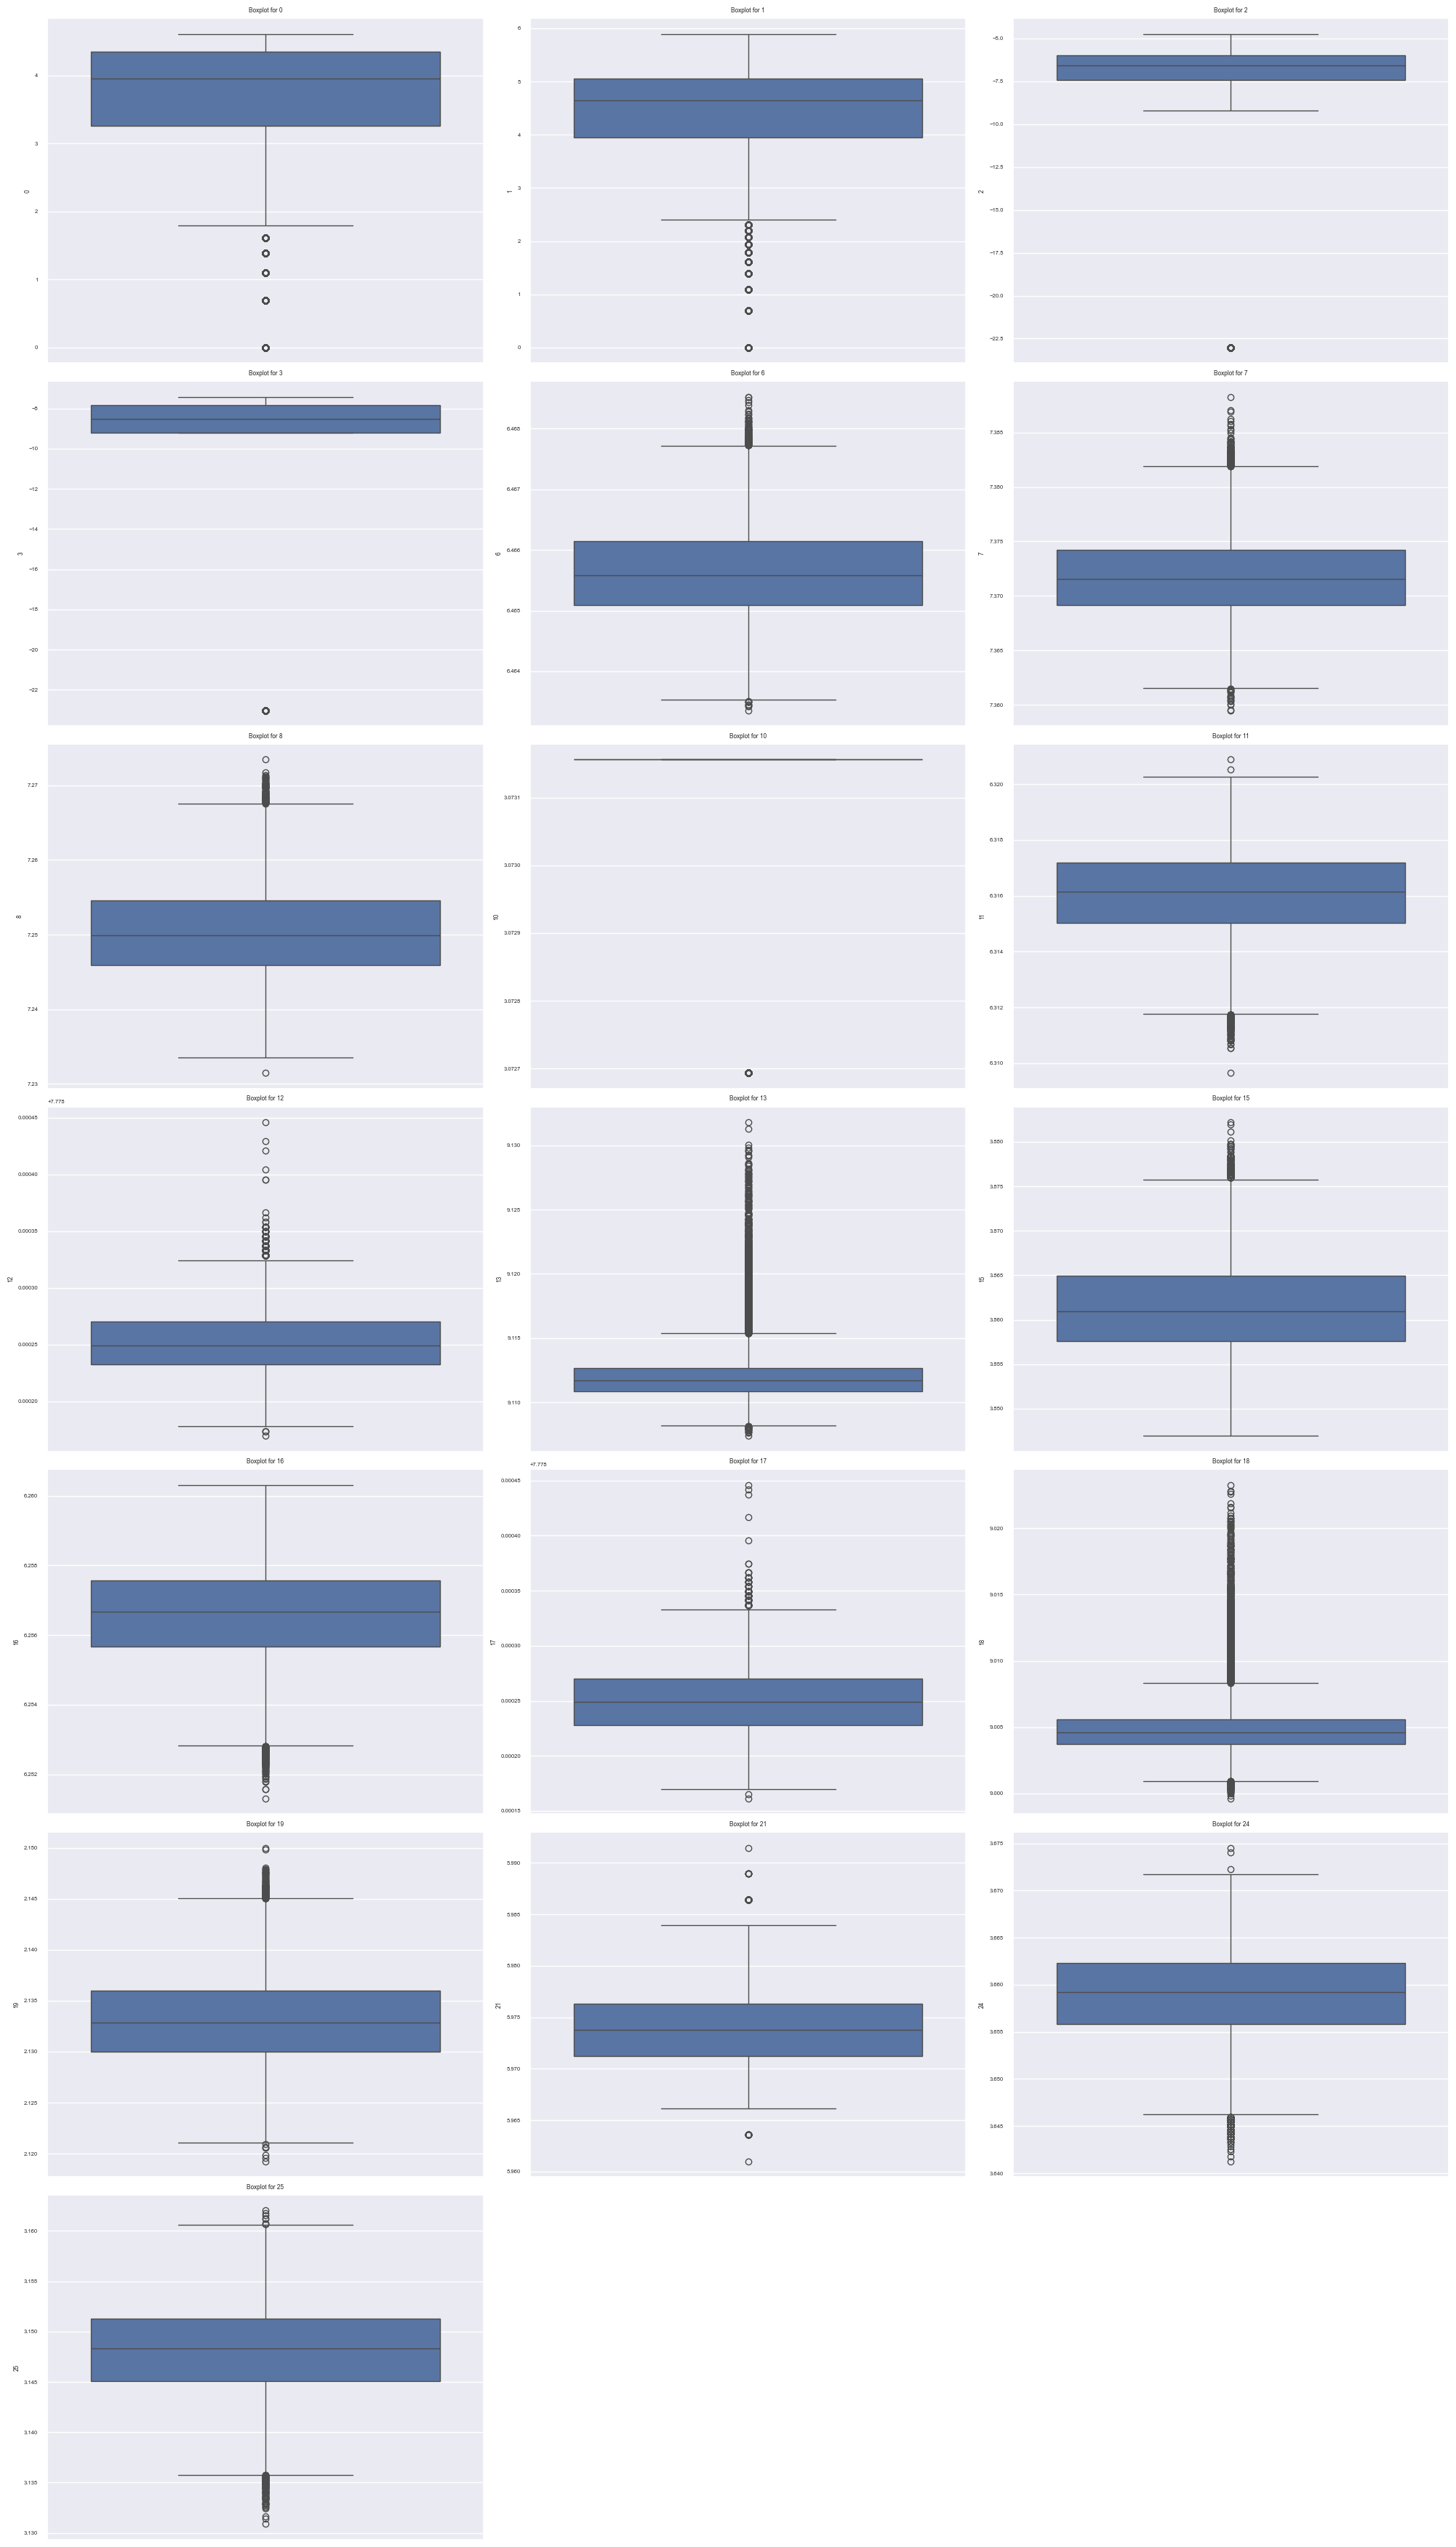

In [24]:
epsilon = 1e-10
df_cleaned = train_df + epsilon
df_log = df_cleaned.map(np.log)


num_columns = df_log.shape[1]
num_rows = (num_columns // 3) + (num_columns % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

for i, col in enumerate(df_log.columns):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(y=df_log[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot for {col}')

for j in range(i + 1, num_rows * 3):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [25]:
df_result = pd.DataFrame(columns=[0,1])

changes = train_df.iloc[:, 0].ne(train_df.iloc[:, 0].shift()).cumsum()


result_rows = []

for unique_val in changes.unique():
    last_index = changes[changes == unique_val].index[-1]
    result_rows.append({'Case':train_df.iloc[last_index, 0], 'Cycles before failure': train_df.iloc[last_index, 1]})

df_result = pd.DataFrame(result_rows)
df_result

Case  Cycles before failure
0      1                    192
1      2                    287
2      3                    179
3      4                    189
4      5                    269
..   ...                    ...
95    96                    336
96    97                    202
97    98                    156
98    99                    185
99   100                    200

[100 rows x 2 columns]

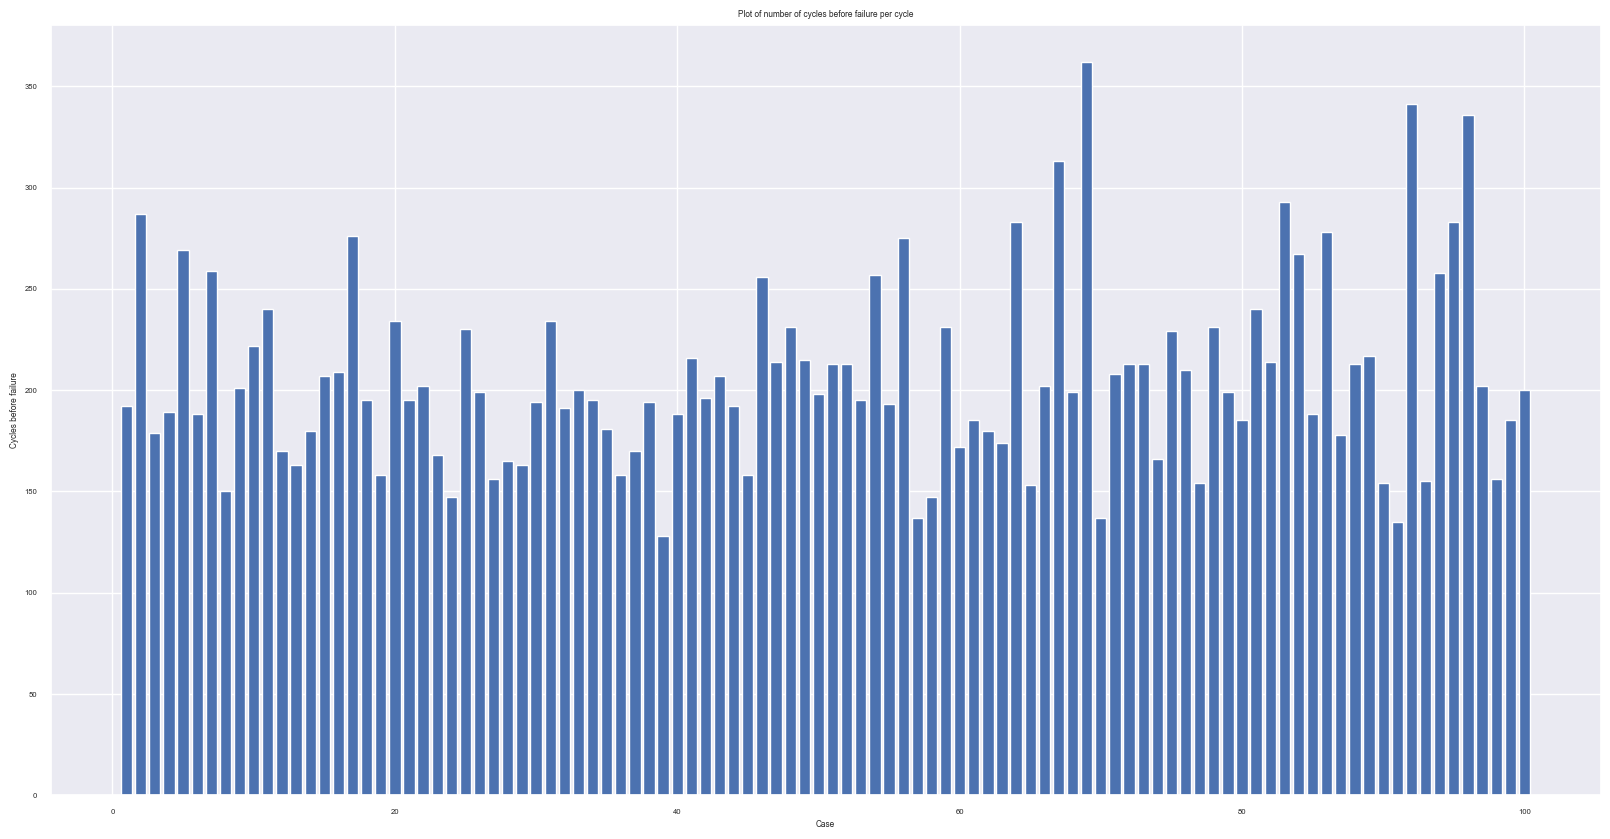

In [26]:
plt.figure(figsize=(20, 10))
plt.bar(df_result['Case'], df_result['Cycles before failure'])

plt.xlabel('Case')
plt.ylabel('Cycles before failure')
plt.title('Plot of number of cycles before failure per cycle')
plt.grid(True)
plt.show()

Correlation matrix 

<Axes: >

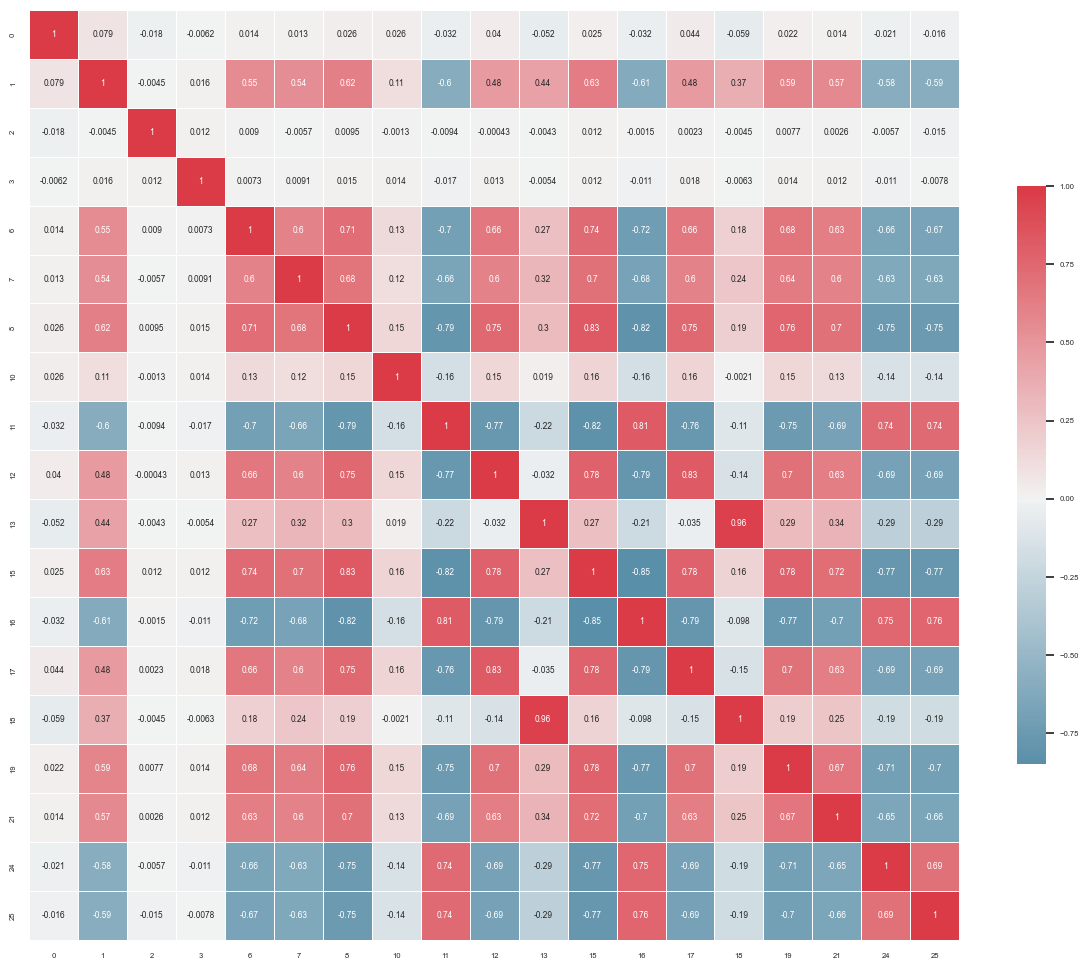

In [27]:
corr = train_df.corr()
sns.set_theme(font_scale=0.5)
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,)

Too many features. K-means doesnt seem to work

### Let's try to work on predicting 50 cycles before the problem arises so we can notify the engineer

In [28]:
rul = pd.DataFrame(train_df.groupby(0)[1].max()).reset_index()

train_df = train_df.merge(rul,how="left", on=[0])

cycles_before_failue = 50

train_df['cbf'] = train_df['1_y'] - train_df['1_x']

rul = pd.DataFrame(train_df_headers.groupby('unit')['cycle'].max()).reset_index()




train_df_headers = train_df_headers.merge(rul,how="left", on=['unit'])
train_df_headers.rename(columns={'cycle_x':'cycle', 'cycle_y':'rul'},inplace=True)
cycles_before_failue = 50

train_df_headers['cbf'] = train_df_headers['rul'] - train_df_headers['cycle']


train_df_headers = train_df_headers.drop(columns=['rul'])


In [29]:
w1 = 30
train_df_headers['failure_within_w1'] = np.where(train_df_headers['cbf'] <= w1, 1, 0 )

w1 = 30
train_df['failure_within_w1'] = np.where(train_df['cbf'] <= w1, 1, 0 )


### Normalize

In [30]:
train_df_headers['cycle_norm'] = train_df_headers["cycle"]

cols_normalize = train_df_headers.columns.difference(['unit','cycle','cbf','failure_within_w1'])

min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df_headers[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df_headers[['unit','cycle','cbf','failure_within_w1']].join(norm_train_df)
train_df_headers = join_df.reindex(columns = train_df_headers.columns)

In [31]:

test_df_headers['cycle_norm'] = test_df_headers['cycle']


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df_headers[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df_headers.index)


test_join_df = test_df_headers[test_df_headers.columns.difference(cols_normalize)].join(norm_test_df)
test_df_headers = test_join_df.reindex(columns = test_df_headers.columns)
test_df_headers = test_df_headers.reset_index(drop=True)

In [32]:

rul = pd.DataFrame(test_df_headers.groupby('unit')['cycle'].max()).reset_index()
rul.columns = ['unit', 'max']
truth_df.columns = ['additional_rul']


truth_df['unit'] = truth_df.index + 1



truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

test_df_headers = test_df_headers.merge(truth_df, on=['unit'], how='left')
test_df_headers['RUL'] = test_df_headers['max'] - test_df_headers['cycle']
test_df_headers.drop('max', axis=1, inplace=True)

test_df_headers['failure_within_w1'] = np.where(test_df_headers['RUL'] <= w1, 1, 0 )

In [33]:
sequence_length = 50

def sequence_generator(feature_df, seq_length, seq_cols):
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [34]:
def label_generator(label_df, seq_length, label): 
    label_array = label_df[label].values
    num_elements = label_array.shape[0]
    return label_array[seq_length:num_elements, :]

In [35]:
label_gen = [label_generator(train_df_headers[train_df_headers['unit']==id], sequence_length, ['failure_within_w1']) 
             for id in train_df_headers['unit'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)


In [36]:
sensor_cols = ['s_' + str(i) for i in range(1,22)]
# sequence_cols_25 = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 'cbf', 'failure_within_w1']
sequence_cols_25 = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) 
print(sequence_cols_25)

['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [38]:
sequences = []
for unit in train_df_headers['unit'].unique():
    filtered_df = train_df_headers[train_df_headers['unit'] == unit]
    generated_sequences = list(sequence_generator(filtered_df, sequence_length, sequence_cols_25))
    sequences.append(generated_sequences)
    
seq_set_f25 = np.concatenate(list(sequences)).astype(np.float32)
seq_set_f25.shape

(15631, 50, 25)

Epoch 1/200 - Train Loss: 0.4713, Val Loss: 0.3359, Val Accuracy: 0.9066
Epoch 2/200 - Train Loss: 0.2958, Val Loss: 0.2607, Val Accuracy: 0.9246
Epoch 3/200 - Train Loss: 0.2441, Val Loss: 0.2295, Val Accuracy: 0.9271
Epoch 4/200 - Train Loss: 0.2182, Val Loss: 0.2070, Val Accuracy: 0.9361
Epoch 5/200 - Train Loss: 0.1973, Val Loss: 0.1937, Val Accuracy: 0.9361
Epoch 6/200 - Train Loss: 0.1841, Val Loss: 0.1824, Val Accuracy: 0.9386
Epoch 7/200 - Train Loss: 0.1741, Val Loss: 0.1748, Val Accuracy: 0.9386
Epoch 8/200 - Train Loss: 0.1681, Val Loss: 0.1804, Val Accuracy: 0.9233
Epoch 9/200 - Train Loss: 0.1656, Val Loss: 0.1627, Val Accuracy: 0.9450
Epoch 10/200 - Train Loss: 0.1596, Val Loss: 0.1589, Val Accuracy: 0.9437
Epoch 11/200 - Train Loss: 0.1566, Val Loss: 0.1566, Val Accuracy: 0.9425
Epoch 12/200 - Train Loss: 0.1524, Val Loss: 0.1623, Val Accuracy: 0.9437
Epoch 13/200 - Train Loss: 0.1518, Val Loss: 0.1493, Val Accuracy: 0.9437
Epoch 14/200 - Train Loss: 0.1483, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_67023/1666354666.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_RNN.load_state_dict(torch.load(model_

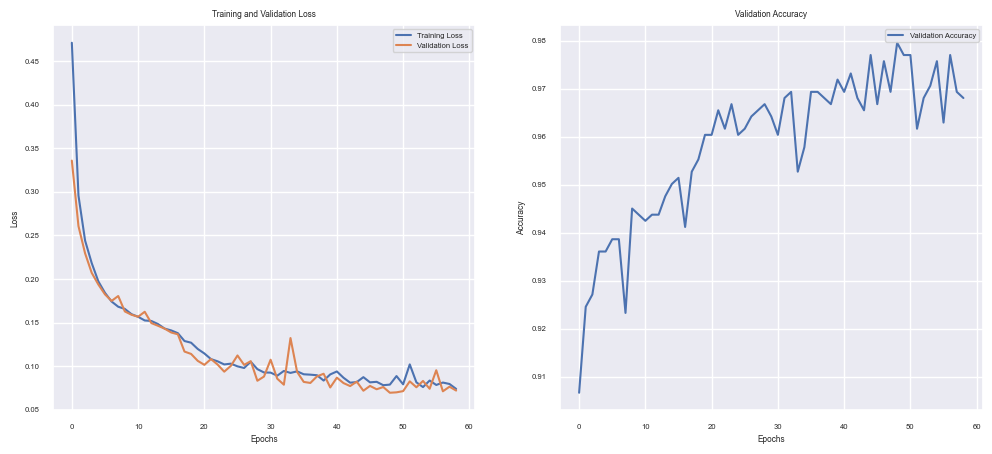

In [41]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_dim, hidden_dim1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x, _ = self.rnn1(x)
        x = self.dropout1(x)
        x, _ = self.rnn2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x

sequence_length = seq_set_f25.shape[1] 
features_dim = seq_set_f25.shape[2]  
out_dim = label_set.shape[1]  
hidden_dim1 = 10
hidden_dim2 = 5
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)

dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_RNN = RNNModel(features_dim, hidden_dim1, hidden_dim2, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)

epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_rnn_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model_RNN.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_RNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model_RNN.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_RNN(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_RNN.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model_RNN.load_state_dict(torch.load(model_path))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


Epoch 1/200 - Train Loss: 0.6658, Val Loss: 0.5749, Val Accuracy: 0.7826
Epoch 2/200 - Train Loss: 0.5219, Val Loss: 0.5224, Val Accuracy: 0.7826
Epoch 3/200 - Train Loss: 0.4912, Val Loss: 0.4691, Val Accuracy: 0.7826
Epoch 4/200 - Train Loss: 0.3072, Val Loss: 0.2312, Val Accuracy: 0.9297
Epoch 5/200 - Train Loss: 0.1768, Val Loss: 0.1568, Val Accuracy: 0.9488
Epoch 6/200 - Train Loss: 0.1378, Val Loss: 0.1341, Val Accuracy: 0.9565
Epoch 7/200 - Train Loss: 0.1224, Val Loss: 0.1402, Val Accuracy: 0.9476
Epoch 8/200 - Train Loss: 0.1077, Val Loss: 0.1043, Val Accuracy: 0.9578
Epoch 9/200 - Train Loss: 0.0985, Val Loss: 0.0940, Val Accuracy: 0.9591
Epoch 10/200 - Train Loss: 0.0926, Val Loss: 0.1004, Val Accuracy: 0.9552
Epoch 11/200 - Train Loss: 0.0836, Val Loss: 0.0846, Val Accuracy: 0.9616
Epoch 12/200 - Train Loss: 0.0837, Val Loss: 0.0963, Val Accuracy: 0.9565
Epoch 13/200 - Train Loss: 0.0786, Val Loss: 0.1088, Val Accuracy: 0.9591
Epoch 14/200 - Train Loss: 0.0775, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_67023/2060392447.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_BiLSTM.load_state_dict(torch.load(mod

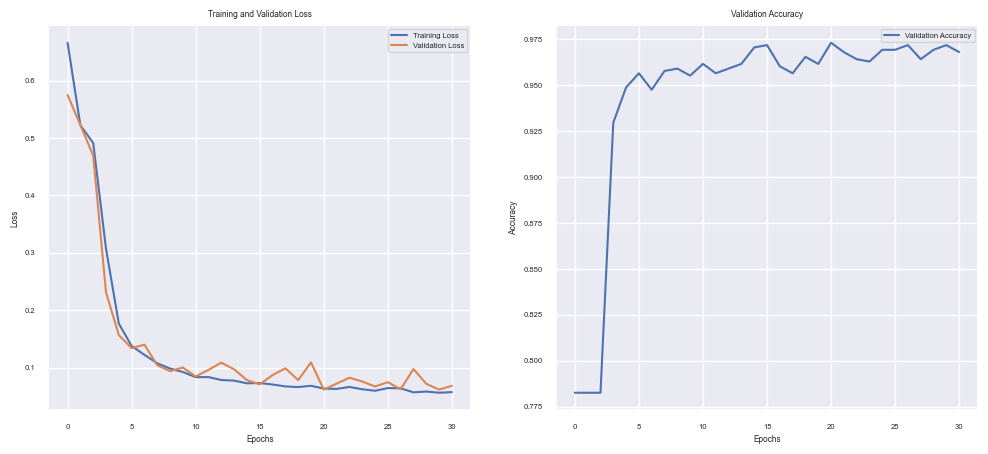

In [42]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim2 * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x

sequence_length = seq_set_f25.shape[1] 
features_dim = seq_set_f25.shape[2]  
out_dim = label_set.shape[1]  
hidden_dim1 = 10
hidden_dim2 = 5
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)

dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_BiLSTM = BiLSTMModel(features_dim, hidden_dim1, hidden_dim2, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_BiLSTM.parameters(), lr=0.001)

epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_bilstm_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model_BiLSTM.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_BiLSTM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model_BiLSTM.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_BiLSTM(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_BiLSTM.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model_BiLSTM.load_state_dict(torch.load(model_path))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


Epoch 1/200 - Train Loss: 0.6140, Val Loss: 0.5206, Val Accuracy: 0.7941
Epoch 2/200 - Train Loss: 0.4491, Val Loss: 0.3797, Val Accuracy: 0.7941
Epoch 3/200 - Train Loss: 0.3310, Val Loss: 0.2747, Val Accuracy: 0.9258
Epoch 4/200 - Train Loss: 0.2461, Val Loss: 0.1960, Val Accuracy: 0.9463
Epoch 5/200 - Train Loss: 0.1871, Val Loss: 0.1437, Val Accuracy: 0.9604
Epoch 6/200 - Train Loss: 0.1605, Val Loss: 0.1328, Val Accuracy: 0.9629
Epoch 7/200 - Train Loss: 0.1394, Val Loss: 0.1220, Val Accuracy: 0.9642
Epoch 8/200 - Train Loss: 0.1254, Val Loss: 0.1349, Val Accuracy: 0.9565
Epoch 9/200 - Train Loss: 0.1181, Val Loss: 0.1046, Val Accuracy: 0.9616
Epoch 10/200 - Train Loss: 0.1065, Val Loss: 0.0938, Val Accuracy: 0.9655
Epoch 11/200 - Train Loss: 0.1055, Val Loss: 0.1006, Val Accuracy: 0.9668
Epoch 12/200 - Train Loss: 0.0992, Val Loss: 0.0777, Val Accuracy: 0.9719
Epoch 13/200 - Train Loss: 0.0949, Val Loss: 0.0742, Val Accuracy: 0.9731
Epoch 14/200 - Train Loss: 0.0899, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_67023/2861744562.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_LSTM.load_state_dict(torch.load(model

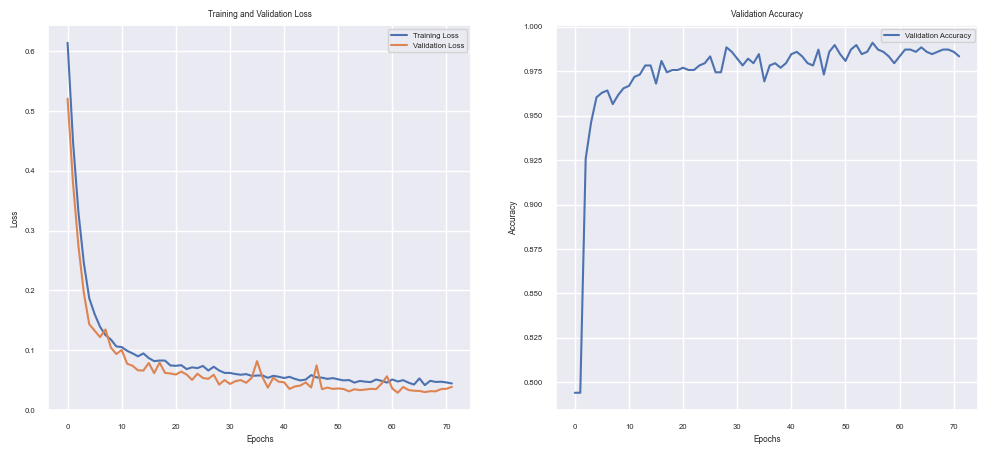

In [43]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x


sequence_length = seq_set_f25.shape[1] 
features_dim = seq_set_f25.shape[2]  
out_dim = label_set.shape[1]  
hidden_dim1 = 10
hidden_dim2 = 5
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)


dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


model_LSTM = LSTMModel(features_dim, hidden_dim1, hidden_dim2, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_LSTM.parameters(), lr=0.001)


epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model_LSTM.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_LSTM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model_LSTM.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_LSTM(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_LSTM.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model_LSTM.load_state_dict(torch.load(model_path))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()




Epoch 1/200 - Train Loss: 0.5854, Val Loss: 0.5308, Val Accuracy: 0.7813
Epoch 2/200 - Train Loss: 0.4973, Val Loss: 0.5208, Val Accuracy: 0.7813
Epoch 3/200 - Train Loss: 0.4559, Val Loss: 0.3980, Val Accuracy: 0.7813
Epoch 4/200 - Train Loss: 0.3177, Val Loss: 0.2814, Val Accuracy: 0.9156
Epoch 5/200 - Train Loss: 0.2256, Val Loss: 0.1857, Val Accuracy: 0.9591
Epoch 6/200 - Train Loss: 0.1663, Val Loss: 0.1408, Val Accuracy: 0.9604
Epoch 7/200 - Train Loss: 0.1350, Val Loss: 0.1180, Val Accuracy: 0.9629
Epoch 8/200 - Train Loss: 0.1133, Val Loss: 0.0995, Val Accuracy: 0.9706
Epoch 9/200 - Train Loss: 0.1034, Val Loss: 0.0888, Val Accuracy: 0.9757
Epoch 10/200 - Train Loss: 0.0945, Val Loss: 0.0830, Val Accuracy: 0.9706
Epoch 11/200 - Train Loss: 0.0792, Val Loss: 0.0741, Val Accuracy: 0.9808
Epoch 12/200 - Train Loss: 0.0857, Val Loss: 0.0706, Val Accuracy: 0.9770
Epoch 13/200 - Train Loss: 0.0858, Val Loss: 0.0665, Val Accuracy: 0.9834
Epoch 14/200 - Train Loss: 0.0734, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_67023/2444545459.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_xLSTM.load_state_dict(torch.load(mode

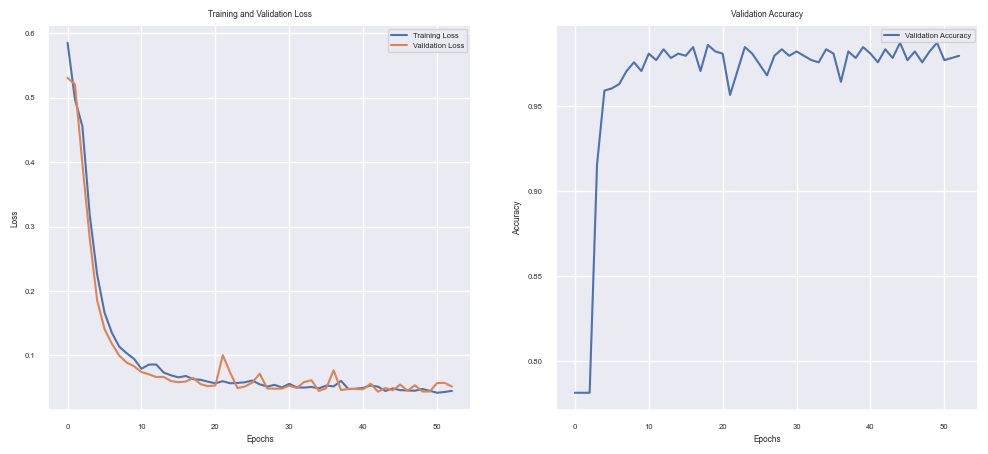

In [44]:
class X_LSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(X_LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        self.input_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.forget_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.cell_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.output_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

        self.modulation_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        combined = torch.cat([x, h_prev], dim=1)

        i_t = torch.sigmoid(self.input_gate(combined))
        f_t = torch.sigmoid(self.forget_gate(combined))
        o_t = torch.sigmoid(self.output_gate(combined))
        c_tilde = torch.tanh(self.cell_gate(combined))

        m_t = torch.sigmoid(self.modulation_gate(combined))

        c_t = f_t * c_prev + i_t * c_tilde * m_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

class X_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(X_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_prob)

        self.cells = nn.ModuleList([X_LSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        for layer in range(self.num_layers):
            outputs = []
            for t in range(seq_len):
                h, c = self.cells[layer](x[:, t, :], (h, c))
                outputs.append(h)
            x = torch.stack(outputs, dim=1)
            if layer != self.num_layers - 1:
                x = self.dropout(x)

        return x, (h, c)

class XLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(XLSTMModel, self).__init__()
        self.xlstm1 = X_LSTM(input_dim, hidden_dim1, num_layers=1, dropout_prob=dropout_prob)
        self.xlstm2 = X_LSTM(hidden_dim1, hidden_dim2, num_layers=1, dropout_prob=dropout_prob)
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x, _ = self.xlstm1(x)
        x, _ = self.xlstm2(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x

sequence_length = seq_set_f25.shape[1] 
features_dim = seq_set_f25.shape[2]  
out_dim = label_set.shape[1]  
hidden_dim1 = 10
hidden_dim2 = 5
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)

dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_xLSTM = XLSTMModel(features_dim, hidden_dim1, hidden_dim2, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_xLSTM.parameters(), lr=0.001)

epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_xlstm_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model_xLSTM.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_xLSTM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model_xLSTM.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_xLSTM(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_xLSTM.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model_xLSTM.load_state_dict(torch.load(model_path))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


Epoch 1/200 - Train Loss: 0.2484, Val Loss: 0.1470, Val Accuracy: 0.9450
Epoch 2/200 - Train Loss: 0.1227, Val Loss: 0.0924, Val Accuracy: 0.9616
Epoch 3/200 - Train Loss: 0.0840, Val Loss: 0.1420, Val Accuracy: 0.9348
Epoch 4/200 - Train Loss: 0.0659, Val Loss: 0.0627, Val Accuracy: 0.9770
Epoch 5/200 - Train Loss: 0.0617, Val Loss: 0.0431, Val Accuracy: 0.9847
Epoch 6/200 - Train Loss: 0.0529, Val Loss: 0.0426, Val Accuracy: 0.9859
Epoch 7/200 - Train Loss: 0.0478, Val Loss: 0.0587, Val Accuracy: 0.9680
Epoch 8/200 - Train Loss: 0.0518, Val Loss: 0.0534, Val Accuracy: 0.9719
Epoch 9/200 - Train Loss: 0.0464, Val Loss: 0.0399, Val Accuracy: 0.9847
Epoch 10/200 - Train Loss: 0.0463, Val Loss: 0.0285, Val Accuracy: 0.9910
Epoch 11/200 - Train Loss: 0.0501, Val Loss: 0.0604, Val Accuracy: 0.9770
Epoch 12/200 - Train Loss: 0.0425, Val Loss: 0.1027, Val Accuracy: 0.9655
Epoch 13/200 - Train Loss: 0.0424, Val Loss: 0.0348, Val Accuracy: 0.9885
Epoch 14/200 - Train Loss: 0.0454, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_67023/1694227826.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trf.load_state_dict(torch.load(model_

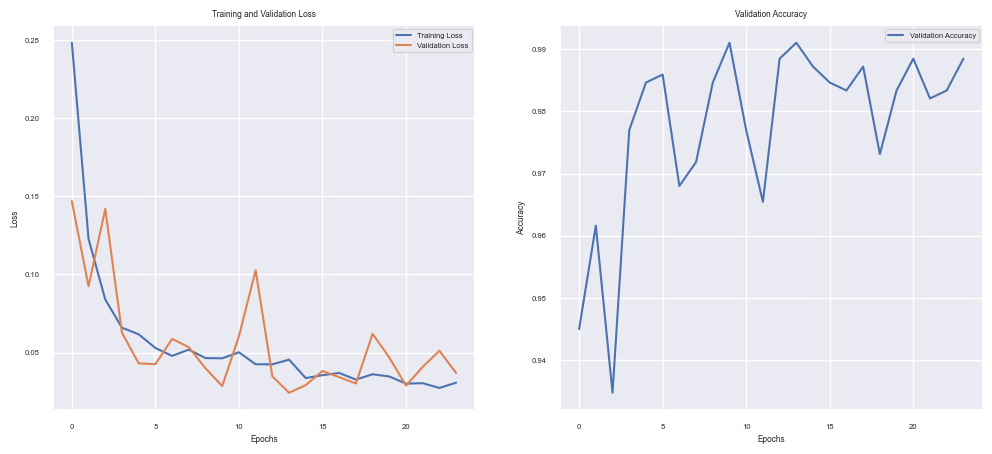

In [45]:

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout_prob):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout_prob
        )
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, input_dim) -> (seq_len, batch_size, hidden_dim)
        x = self.transformer_decoder(x, x)
        x = x.permute(1, 0, 2)  # back to (batch_size, seq_len, hidden_dim)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x

sequence_length = seq_set_f25.shape[1]
features_dim = seq_set_f25.shape[2]
out_dim = label_set.shape[1]
hidden_dim = 64  
num_layers = 2
num_heads = 4
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)

dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_trf = TransformerModel(features_dim, hidden_dim, num_layers, num_heads, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_trf.parameters(), lr=0.001)

epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_transformer_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model_trf.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_trf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model_trf.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_trf(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_trf.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model_trf.load_state_dict(torch.load(model_path))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


In [46]:
test_df_headers.head(5)


unit  cycle  setting_1  setting_2  setting_3  s_1       s_2       s_3  \
0     1      1   0.632184   0.750000        0.0  0.0  0.545181  0.310661   
1     1      2   0.344828   0.250000        0.0  0.0  0.150602  0.379551   
2     1      3   0.517241   0.583333        0.0  0.0  0.376506  0.346632   
3     1      4   0.741379   0.500000        0.0  0.0  0.370482  0.285154   
4     1      5   0.580460   0.500000        0.0  0.0  0.391566  0.352082   

        s_4  s_5  ...      s_15  s_16      s_17  s_18  s_19      s_20  \
0  0.269413  0.0  ...  0.308965   0.0  0.333333   0.0   0.0  0.558140   
1  0.222316  0.0  ...  0.213159   0.0  0.416667   0.0   0.0  0.682171   
2  0.322248  0.0  ...  0.458638   0.0  0.416667   0.0   0.0  0.728682   
3  0.408001  0.0  ...  0.257022   0.0  0.250000   0.0   0.0  0.666667   
4  0.332039  0.0  ...  0.300885   0.0  0.166667   0.0   0.0  0.658915   

       s_21  cycle_norm    RUL  failure_within_w1  
0  0.661834     0.00000  142.0                  0  
1  0.686827     0.00277  141.0                  0  
2  0.721348     0.00554  140.0                  0  
3  0.662110     0.00831  139.0                  0  
4  0.716377     0.01108  138.0                  0  

[5 rows x 29 columns]

In [47]:
truth_df.head(5)

unit    max
0     1  143.0
1     2  147.0
2     3  195.0
3     4  188.0
4     5  189.0

In [53]:
import os

In [65]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score


# Test set accuracy for all models


### Test set accuracy for LSTM

Accuracy: 96.47%


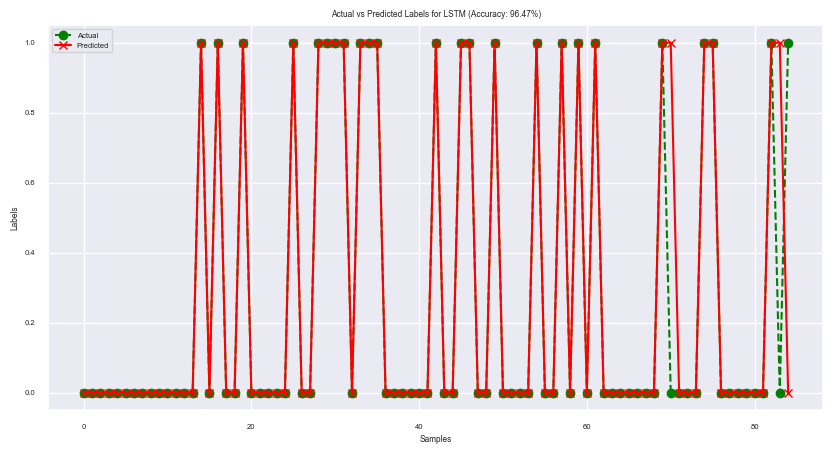

In [126]:

last_test_seq = [test_df_headers[test_df_headers['unit']==id][sequence_cols_25].values[-sequence_length:] 
                       for id in test_df_headers['unit'].unique() if len(test_df[test_df_headers['unit']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

y_mask = [len(test_df_headers[test_df_headers['unit']==id]) >= sequence_length for id in test_df_headers['unit'].unique()]
last_test_label = test_df_headers.groupby('unit')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

import torch
from sklearn.metrics import accuracy_score

last_test_seq_tensor = torch.tensor(last_test_seq, dtype=torch.float32)
last_test_label_tensor = torch.tensor(last_test_label, dtype=torch.float32)

model_LSTM.eval()

with torch.no_grad():
    predictions = model_LSTM(last_test_seq_tensor)

predictions_binary = (predictions > 0.5).int()

last_test_label_int = last_test_label_tensor.int()

accuracy = accuracy_score(last_test_label_int.numpy(), predictions_binary.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(last_test_label_int.numpy(), label='Actual', marker='o', linestyle='--', color='green')
plt.plot(predictions_binary.numpy(), label='Predicted', marker='x', linestyle='-', color='red')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.title(f'Actual vs Predicted Labels for LSTM (Accuracy: {accuracy * 100:.2f}%)')
plt.legend()
plt.show()



### Test set accuracy for RNN

Accuracy: 96.47%


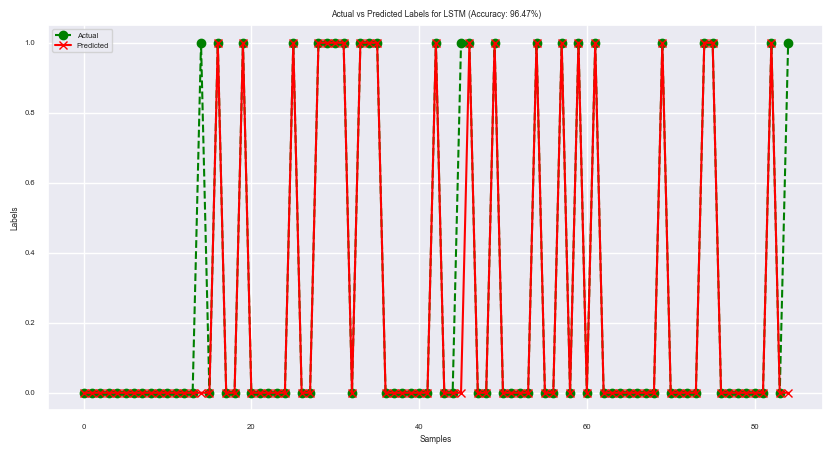

In [127]:
last_test_seq_tensor = torch.tensor(last_test_seq, dtype=torch.float32)
last_test_label_tensor = torch.tensor(last_test_label, dtype=torch.float32)

model_RNN.eval()

with torch.no_grad():
    predictions = model_RNN(last_test_seq_tensor)

predictions_binary = (predictions > 0.5).int()

last_test_label_int = last_test_label_tensor.int()

accuracy = accuracy_score(last_test_label_int.numpy(), predictions_binary.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(last_test_label_int.numpy(), label='Actual', marker='o', linestyle='--', color='green')
plt.plot(predictions_binary.numpy(), label='Predicted', marker='x', linestyle='-', color='red')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.title(f'Actual vs Predicted Labels for RNN (Accuracy: {accuracy * 100:.2f}%)')
plt.legend()
plt.show()


### Test set accuracy for decoder only transformer

Accuracy: 98.82%


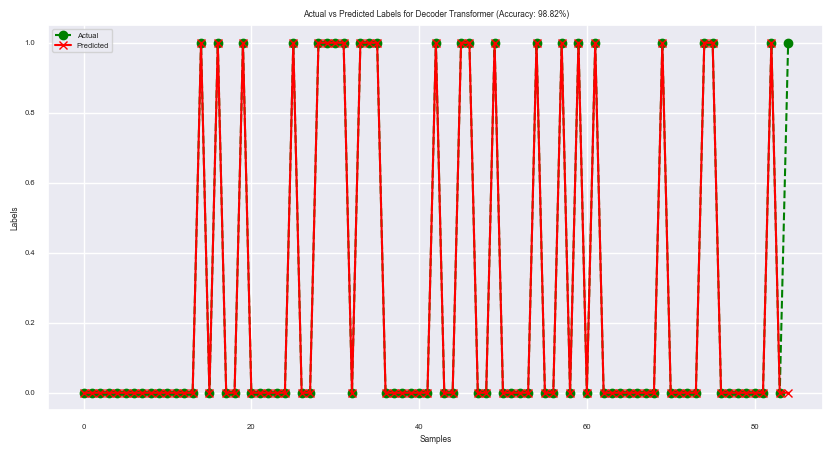

In [129]:
last_test_seq_tensor = torch.tensor(last_test_seq, dtype=torch.float32)
last_test_label_tensor = torch.tensor(last_test_label, dtype=torch.float32)

model_trf.eval()

with torch.no_grad():
    predictions = model_trf(last_test_seq_tensor)

predictions_binary = (predictions > 0.5).int()

last_test_label_int = last_test_label_tensor.int()

accuracy = accuracy_score(last_test_label_int.numpy(), predictions_binary.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(last_test_label_int.numpy(), label='Actual', marker='o', linestyle='--', color='green')
plt.plot(predictions_binary.numpy(), label='Predicted', marker='x', linestyle='-', color='red')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.title(f'Actual vs Predicted Labels for Decoder Transformer (Accuracy: {accuracy * 100:.2f}%)')
plt.legend()
plt.show()



### Test set accuracy or bi lstm

Accuracy: 95.29%


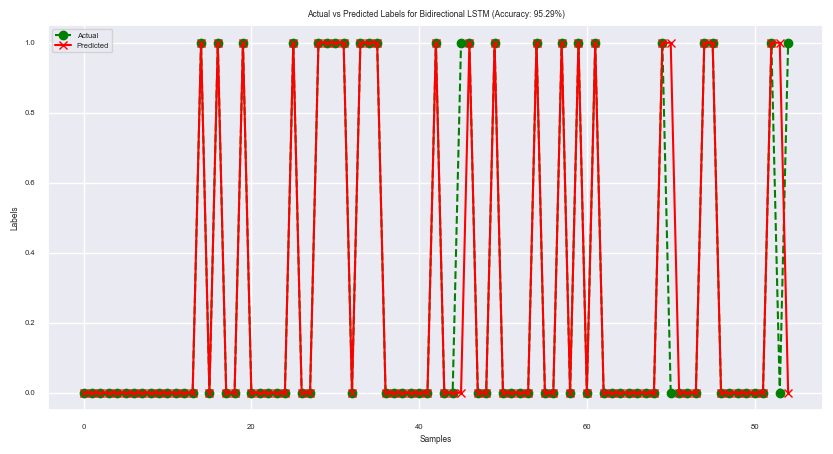

In [131]:
last_test_seq_tensor = torch.tensor(last_test_seq, dtype=torch.float32)
last_test_label_tensor = torch.tensor(last_test_label, dtype=torch.float32)

model_BiLSTM.eval()

with torch.no_grad():
    predictions = model_BiLSTM(last_test_seq_tensor)

predictions_binary = (predictions > 0.5).int()

last_test_label_int = last_test_label_tensor.int()

accuracy = accuracy_score(last_test_label_int.numpy(), predictions_binary.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(last_test_label_int.numpy(), label='Actual', marker='o', linestyle='--', color='green')
plt.plot(predictions_binary.numpy(), label='Predicted', marker='x', linestyle='-', color='red')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.title(f'Actual vs Predicted Labels for Bidirectional LSTM (Accuracy: {accuracy * 100:.2f}%)')
plt.legend()
plt.show()



### Test set accuracy for xLSTM

Accuracy: 96.47%


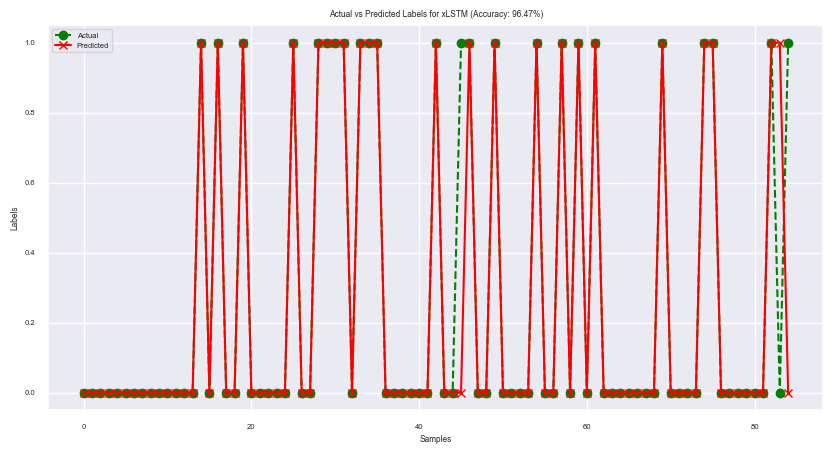

In [133]:
last_test_seq_tensor = torch.tensor(last_test_seq, dtype=torch.float32)
last_test_label_tensor = torch.tensor(last_test_label, dtype=torch.float32)

model_xLSTM.eval()
model_xLSTM.to("cpu")

with torch.no_grad():
    predictions = model_xLSTM(last_test_seq_tensor)

predictions_binary = (predictions > 0.5).int()

last_test_label_int = last_test_label_tensor.int()

accuracy = accuracy_score(last_test_label_int.numpy(), predictions_binary.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(last_test_label_int.numpy(), label='Actual', marker='o', linestyle='--', color='green')
plt.plot(predictions_binary.numpy(), label='Predicted', marker='x', linestyle='-', color='red')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.title(f'Actual vs Predicted Labels for xLSTM (Accuracy: {accuracy * 100:.2f}%)')
plt.legend()
plt.show()


In [134]:
model = model_trf

In [135]:
background = seq_set_f25_tensor[:100]
test_data = seq_set_f25_tensor[-100:]

def predict(inputs):
    model.eval()
    with torch.no_grad():
        return model(inputs).detach().cpu().numpy()

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_data)

shap.initjs()
shap.force_plot(np.mean(shap_values[0]), shap_values[0][0], test_data[0].numpy())


In [136]:
# import matplotlib.pyplot as plt
# import shap
# import torch


# background = seq_set_f25_tensor[:100]
# test_data = seq_set_f25_tensor[-50:]

# def predict(inputs):
#     model.eval()
#     with torch.no_grad():
#         return model(inputs).detach().cpu().numpy()

# explainer = shap.GradientExplainer(model, background)
# shap_values = explainer.shap_values(test_data)
# num_instances_to_plot = len(test_data)

# feature_names = [
#     'setting_1', 'setting_2', 'setting_3', 'cycle_norm', "(Fan inlet temperature) (◦R)",
#     "(LPC outlet temperature) (◦R)", "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)",
#     "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)", "(HPC outlet pressure) (psia)",
#     "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)",
#     "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)",
#     "(Corrected core speed) (rpm)", "(Bypass Ratio)", "(Burner fuel-air ratio)", "(Bleed Enthalpy)",
#     "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
#     "(Low-pressure turbines Cool air flow)"
# ]

# fig, axes = plt.subplots(num_instances_to_plot, 1, figsize=(20, 10 * num_instances_to_plot))


# if num_instances_to_plot == 1:
#     axes = [axes]


# for i in range(num_instances_to_plot):
#     shap_values_instance = shap_values[0][i]
    

#     if len(shap_values_instance.shape) > 1:
#         shap_values_instance = shap_values_instance.flatten()
    

#     axes[i].barh(range(len(shap_values_instance)), shap_values_instance, color='skyblue')
#     axes[i].set_yticks(range(len(feature_names)))
#     axes[i].set_yticklabels(feature_names, fontsize=12)
#     axes[i].set_xlabel('SHAP Value', fontsize=12)
#     axes[i].set_ylabel('Features', fontsize=12)
#     axes[i].set_title(f'SHAP Values for Instance {i}', fontsize=14)
#     axes[i].grid(True, linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()


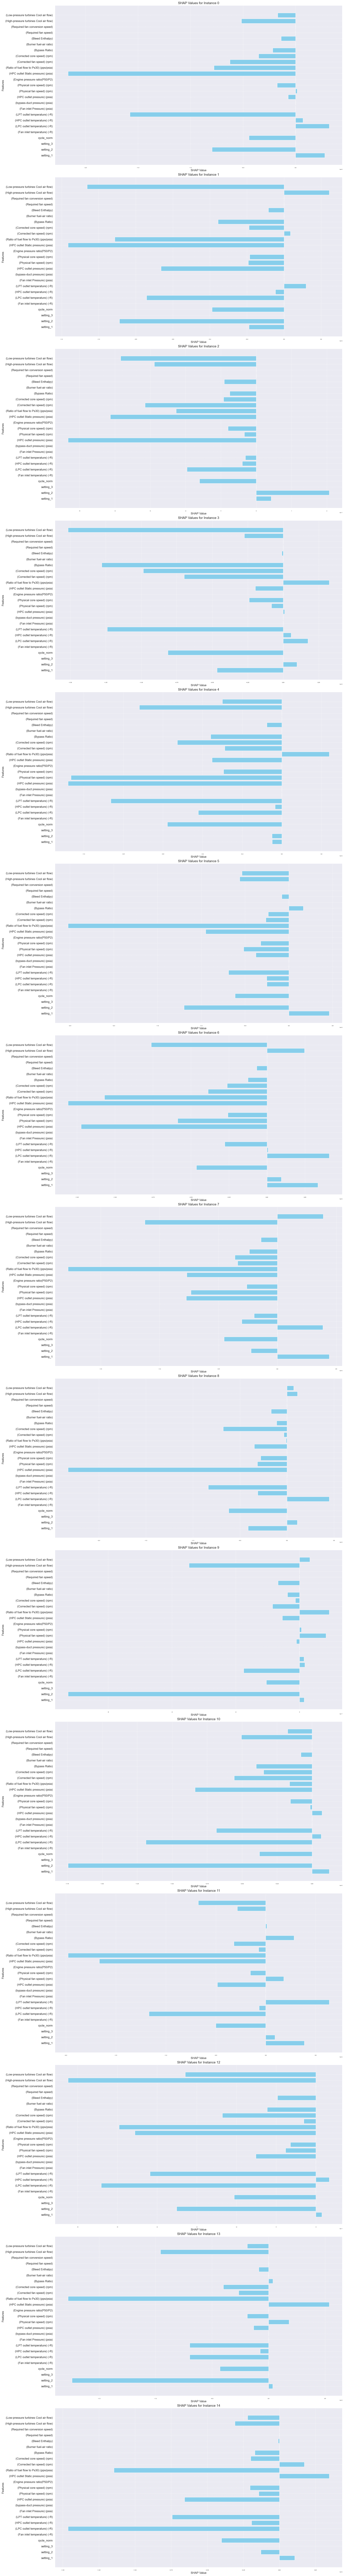

In [137]:
import matplotlib.pyplot as plt
import shap
import torch

background = seq_set_f25_tensor[:100]
test_data = seq_set_f25_tensor[-50:]

def predict(inputs):
    model.eval()
    with torch.no_grad():
        return model(inputs).detach().cpu().numpy()

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_data)

num_instances_to_plot = 15

feature_names = [
    'setting_1', 'setting_2', 'setting_3', 'cycle_norm', "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)", "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)", "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)",
    "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)", "(Bypass Ratio)", "(Burner fuel-air ratio)", "(Bleed Enthalpy)",
    "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]

fig, axes = plt.subplots(num_instances_to_plot, 1, figsize=(20, 10 * num_instances_to_plot))

if num_instances_to_plot == 1:
    axes = [axes]

for i in range(num_instances_to_plot):
    shap_values_instance = shap_values[0][i]

    if len(shap_values_instance.shape) > 1:
        shap_values_instance = shap_values_instance.flatten()

    axes[i].barh(range(len(shap_values_instance)), shap_values_instance, color='skyblue')
    axes[i].set_yticks(range(len(feature_names)))
    axes[i].set_yticklabels(feature_names, fontsize=12)
    axes[i].set_xlabel('SHAP Value', fontsize=12)
    axes[i].set_ylabel('Features', fontsize=12)
    axes[i].set_title(f'SHAP Values for Instance {i}', fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [138]:
shap_values.shape

(50, 50, 25, 1)

In [139]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3.1-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16},
  device="cpu",
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


In [140]:
# prompt = "Explain the theory of relativity."
# output = pipeline(
#     prompt, 
#     max_length=50,  
#     num_return_sequences=1, 
#     truncation=True  
# )

# print(output[0]['generated_text'])
